In [4]:
import numpy as np
from scipy.io import loadmat
from matplotlib import pyplot as plt
%matplotlib inline
import imp
import time
from sklearn.cluster import KMeans

__DEBUG__ = False

In [5]:
def project_2d(X):
    mu = X.mean(0)
    C = np.cov(X - mu, rowvar=False)
    d, u = np.linalg.eigh(C)
    U = u.T[::-1]
    Z = np.dot(X - mu, U[:2].T)
    return Z

def sample_unit_ball(shape):
    """sample k points from Rd unit ball"""
    xs = np.random.normal(0.0, 1.0, shape)
    xs = xs / np.linalg.norm(xs, axis = 1)[:,np.newaxis]
    return xs

def sample_uniform(a, b, size):
    """sample [size] shaped matrix with elements uniformly
    from [a,b]"""
    x = np.random.random(size)
    x = x * (b-a) + a
    return x / np.linalg.norm(x, axis = 1)[:,np.newaxis]

def bin_hash(X, k = 8):
    ''' non-deterministically hash rows of X by the sign
    of its dot product with zs, which are uniform random 
    points on unit sphere in Rd'''
    n, d = X.shape
    zs = sample_unit_ball((k, d))
    hash_val = np.dot(X, zs.T)
    hash_val = np.sign(hash_val)
    # merge the hashval into an int
    def row_to_int(x):
        acc = 0
        for elm in x:
            acc = acc * 2 + elm
        return acc
    int_val = np.apply_along_axis(row_to_int, 1, hash_val)
    return int_val, zs

def nearest_bin(X, zs = None, k=8):
    '''
    randomly sample k vectors from unit ball. Categorize rows of 
    X by its dot product with the k vectors.
    '''
    n, d = X.shape
    if zs is None:
        zs = sample_unit_ball((k, d))
    assert np.allclose(np.linalg.norm(X,axis=1), np.ones(n))
    assert np.allclose(np.linalg.norm(zs,axis=1), np.ones(k))
    X = X - EPSILON
    hash_val = np.dot(X, zs.T)
    bins, binvals = np.argmax(hash_val, axis = 1), np.max(hash_val, axis=1)
    return bins, binvals, zs, np.dot(zs, zs.T)

def gen_fake_dataset(N, d, k, w = 100):
    '''
    generate N Rd vectors, grouped around k anchor vectors, in the first octant
    then add [w] vectors in the all-negative octant
    '''
    def add_noise(x, eps = EPSILON):
        disruption = sample_unit_ball((1,d)) * eps
        return x + disruption
    zs = np.random.normal(0.0, 1.0, (k,d))
    zs[zs<0] = 0
    zs = zs / np.linalg.norm(zs, axis = 1)[:,np.newaxis]
    ret = np.zeros((N,d))
    for i in range(N):
        ki = np.random.randint(0, k)
        ret[i,:] = add_noise(zs[ki,:], eps = 1e-10)
        
    # add w vectors
    ws = np.random.normal(0.0, 1.0, (w,d))
    ws[ws>0] = 0
    ws = ws / np.linalg.norm(ws, axis = 1)[:,np.newaxis]
    ret = np.vstack((ret, ws))
    return ret, zs

def in_class_variance(X, labels, k):
    N, d = X.shape
    out, centers = np.zeros(k), np.zeros((k,d))
    for i in range(k):
        xx = X[np.where(labels == i)]
        mean = np.mean(xx,axis=0)
        dot = np.dot(xx, mean[:, np.newaxis])
        out[i] = np.mean(dot)
        centers[i,:] = mean / np.linalg.norm(mean)
    return out, centers

def pretty_print(mat):
    k,d = mat.shape
    print '['
    for row in mat:
        s = ', '.join(['{:4.2f}'.format(x) for x in row])
        print s
    print ']'
    
def accuracy(ans, truth):
    l = len(np.where(ans != truth)[0])
    h, w = truth.shape
    return 1 - l * 1. / h / w

def neg_accuracy(ans, truth):
    neg_t = len(np.where(truth < 0)[0])
    neg_a = len(np.where(ans < 0)[0])
    return neg_a * 1. / neg_t

In [6]:
'''Loading data'''
Xs = loadmat('JSMF-nips/nips_N-5000_train.mat')
# normalize it
# for i in range(Xs.shape[-1]):
#     Xs[...,i] = Xs[...,i] / np.linalg.norm(Xs[...,i], axis=1)[:,np.newaxis]
print Xs.keys()

EPSILON = 1e-8

['C', 'D', '__header__', '__globals__', '__version__', 'D2']


In [7]:
import h5py
with h5py.File('JSMF-nips/nips_N-5000_train_H.mat', 'r') as f:
    print f.keys()
    print f['H'].shape, type(f['H'])
    X = f['H'][()].T

[u'H']
(1348, 5000) <class 'h5py._hl.dataset.Dataset'>


In [8]:
X_raw = loadmat('X_nips_5iter_20topics.mat')['X']

X = X_raw / np.linalg.norm(X_raw,axis=1)[:,np.newaxis]
print X.shape
print sum(X_raw[1])

(5000, 20)
0.00828332675758


### Random hashing experiments

1.0
(5000, 2)
8
['-1,-1', '0,1', '0,0', '1,0', '1,1', '0,-1', '-1,0', '-1,1']
[18, 915, 2459, 14, 5, 98, 1372, 119]


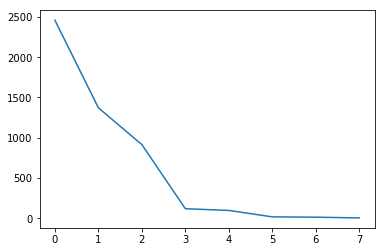

In [26]:
'''random LSH hashing experiments'''
from collections import defaultdict
def collect_label(hash_val):
    N, k = hash_val.shape
    bins = defaultdict(int)
    for row in hash_val:
        row_k = ','.join([str(x) for x in row])
#         print row_k; break
        bins[row_k] += 1
    return bins
        
r, k = 2.5, 2
N, d = X.shape
print np.average(np.linalg.norm(X, axis=1))
a, b = np.zeros((k,d)), np.zeros(k)
for i in range(k):
    a[i] = np.random.multivariate_normal(np.zeros(d), np.eye(d))
    b[i] = np.random.random() * r

hash_val = np.floor((X.dot(a.T) + b) / r).astype(int)
print hash_val.shape

bins = collect_label(hash_val)
print len(bins)
print bins.keys()
print bins.values()
plt.plot(sorted(bins.values())[:-50:-1])

(5000, 4) [ 1.  1. -1. -1.]
[2 0 3 1 4]


(array([  499.,     0.,   189.,     0.,     0.,  4156.,     0.,    91.,
            0.,    65.]),
 array([ 0. ,  0.4,  0.8,  1.2,  1.6,  2. ,  2.4,  2.8,  3.2,  3.6,  4. ]),
 <a list of 10 Patch objects>)

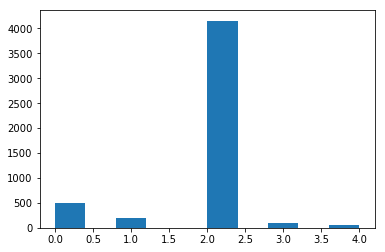

In [12]:
N, d = X.shape
# k = int(np.log(np.log(N))) + 1
k = 4

a = np.zeros((k,d))
for i in range(k):
    a[i] = np.random.multivariate_normal(np.zeros(d), np.eye(d))


signs = np.sign(X.dot(a.T) )
print signs.shape, signs[0]

def min_wise_hash(X):
    '''X are Nxd collection of binary vectors'''
    N, d = X.shape
    perm = np.random.permutation(range(d))
    perm = np.append(perm, d)
    print perm
    hash_vals = np.zeros(N)
    for i in range(N):
        j = 0
        while j < d and X[i,j] < 0:
            j+=1

        hash_vals[i] = perm[j]
    return hash_vals

bins = min_wise_hash(signs)
plt.hist(bins)

(5000, 5000)
1 1180.0
4 2985.0
7 3711.0
10 4057.0
13 4263.0
16 4391.0
19 4496.0
22 4552.0
25 4601.0
28 4629.0


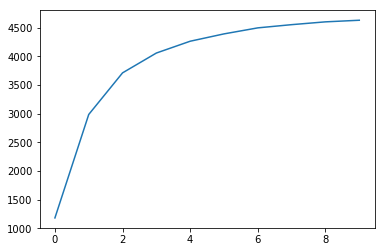

In [115]:
# verify closest point is in the same bin
pairwise_dist = X.dot(X.T)
print pairwise_dist.shape

def compute_accuracy(k):
    '''returns percentage of xi's where one among the first k closest
    neighbors is in the same cluster as xi
    '''
    closest_index = np.argpartition(pairwise_dist, k-1, axis=0)
    # ci2 = np.argmin(pairwise_dist, axis=0)
#     print closest_index.shape
    # print np.allclose(ci2, closest_index[0,:])

    N, d = X.shape
    correct = np.zeros(N)
    for i in range(10,N):
        candidate_bins = bins[closest_index[:k, i]]
        correct[i] = np.any(bins[i] == candidate_bins)

    return np.sum(correct)

N = 10
stats = np.zeros(N)
for k in range(N):
    stats[k] = compute_accuracy(3*k+1)
    print 3*k+1, stats[k]
plt.plot(stats)

### Note about the experiment below

In d=1000, most of the dot products acquired, no matter between x and z or just between z's, are very close to 0. This is a display of the Curse of Dimensionality and probably need to addressed. For now, first see how the naive triangular inequality works out.

In [28]:
'''Sanity check'''
XXt = X.dot(X.T)
C = Xs['C']
print np.mean(XXt), np.mean(C)
print np.linalg.norm(X, axis=1)[:10]

0.390143288256 3.99999999997e-08
[ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.]


In [8]:
def find_negative_dot_product_bf(X):
    h, _ = X.shape
    ret = np.zeros((h,h))
    start_time = time.time()
    neg_entry = 0
    for i in range(h):
        for j in range(h):
            dotp = np.dot(X[i,:],X[j,:])
            if dotp < 0:
                neg_entry += 1
                ret[i,j] = dotp
    end_time = time.time()
    print("Compute {}*{} dot products in {} seconds, found {} neg entries"\
          .format(h,h,end_time-start_time, neg_entry))
    return ret

# X = sample_uniform(-0.5, 1, (1000,10))
# X = Xs[:,:,-1]
# X = sample_unit_ball((1000,100))
# X, zs =  gen_fake_dataset(1606, 15, 8, w = 10)
print X.shape, Xs['C'].shape
bf_result = find_negative_dot_product_bf(X)

(5000, 20) (5000, 5000)
Compute 5000*5000 dot products in 46.8766729832 seconds, found 491936 neg entries


In [51]:
def find_negative_dot_product_hash(X, k = 1, zs =None, labels = None, bound = 0.5):
    start_time = time.time()
    h, _ = X.shape
    bins, binvals, _, bin_dists = nearest_bin(X, zs=zs, k = k)
    bin_dists, binvals = bin_dists - EPSILON, binvals - EPSILON
    binangles, zangles = np.arccos(binvals), np.arccos(bin_dists)
    ret = np.zeros((h,h))
    N = 0
    pi_over_2 = np.pi/2
    for i in range(h):
        for j in range(h):
            bi, bj = bins[i], bins[j]
            if zangles[bi,bj]+binangles[i]+binangles[j] < pi_over_2 + bound:
                continue
            dotp = np.dot(X[i,:],X[j,:])
            N += 1
            if dotp < 0:
                ret[i,j] = dotp
    end_time = time.time()
    print("Compute {} dot products in {} seconds".format(N,end_time-start_time))
    return ret
    
k=20
s1 = time.time()
kmeans = KMeans(n_clusters=k).fit(X)
_, zs= in_class_variance(X, kmeans.labels_, k)
hash_result = find_negative_dot_product_hash(X, zs=zs, k = k, labels = kmeans.labels_)
s2 = time.time()
print("[k={}] Accuracy {:.2f}%. Total time: {} secs".format(k,100 * neg_accuracy(hash_result, bf_result), s2-s1))

Compute 14494468 dot products in 67.4588289261 seconds
[k=20] Accuracy 96.57%. Total time: 68.3218851089 secs


In [52]:
def main(bound, k = 20):
    s1 = time.time()
    kmeans = KMeans(n_clusters=k).fit(X)
    _, zs= in_class_variance(X, kmeans.labels_, k)
    hash_result = find_negative_dot_product_hash(X, zs=zs, k = k, labels = kmeans.labels_, bound=bound)
    s2 = time.time()
    print("[k={}] Accuracy {:.2f}%. Total time: {} secs".format(k,100 * neg_accuracy(hash_result, bf_result), s2-s1))
    return zs

# for k in [5,10,20,50,100,200,500][::-1]:
# for k in [100]:
for b in 0.1 * np.array(range(1,10)):
    main(b)

Compute 21604164 dot products in 82.532118082 seconds
[k=20] Accuracy 100.00%. Total time: 83.4682660103 secs
Compute 20741012 dot products in 80.2061691284 seconds
[k=20] Accuracy 100.00%. Total time: 81.1811339855 secs
Compute 18818450 dot products in 76.5589280128 seconds
[k=20] Accuracy 99.93%. Total time: 77.5140659809 secs
Compute 16909304 dot products in 71.9854807854 seconds
[k=20] Accuracy 99.40%. Total time: 72.9183988571 secs
Compute 14730324 dot products in 66.6218039989 seconds
[k=20] Accuracy 96.54%. Total time: 67.4920928478 secs
Compute 11780797 dot products in 59.7290549278 seconds
[k=20] Accuracy 88.88%. Total time: 60.6797749996 secs
Compute 9001308 dot products in 53.4293301105 seconds
[k=20] Accuracy 76.06%. Total time: 54.2185008526 secs
Compute 6029084 dot products in 46.2822420597 seconds
[k=20] Accuracy 55.39%. Total time: 47.1583938599 secs
Compute 3670798 dot products in 40.6797640324 seconds
[k=20] Accuracy 38.86%. Total time: 41.6775989532 secs


## Structures of bins

In [35]:
# X = Xs[...,-1]
X = X_raw
N, d = X.shape
print(X.shape)
k = 20
kmeans = KMeans(n_clusters=k).fit(X)
_, zs= in_class_variance(X, kmeans.labels_, k)
'''Structure of centers'''
# print zs.shape
# z2d = project_2d(zs)
# print z2d.shape
# plt.title('2d projection of centers')
# plt.scatter(z2d[:,0], z2d[:,1])

# # compute mean dot product between two vectors
# dot_products = np.dot(zs, zs.T)
# mean_dp = np.mean(dot_products, axis=0)

# plt.figure()
# plt.title('all dot products of centers')
# plt.hist(dot_products.flatten())

# plt.figure()
# plt.title('mean dot products of centers')
# plt.hist(mean_dp)

# mean_in_bin_dp = np.zeros(k)
# for bin_id in range(k):
#     points, center = X[np.where(kmeans.labels_ == bin_id)], zs[bin_id]
#     dp = [np.dot(points[i], center) for i in range(points.shape[0])]
#     mean_in_bin_dp[bin_id] = np.mean(dp)
# plt.figure()
# plt.title('mean in-cluster dot products for {} clusters'.format(k))
# plt.hist(mean_in_bin_dp)
    

(5000, 20)


'Structure of centers'

(3930, 20)
(28, 20)
(3, 20)
(28, 20)
(730, 20)
(1, 20)
(230, 20)
(1, 20)
(28, 20)
(5, 20)
(3, 20)
(1, 20)
(1, 20)
(1, 20)
(1, 20)
(1, 20)
(2, 20)
(1, 20)
(2, 20)
(3, 20)


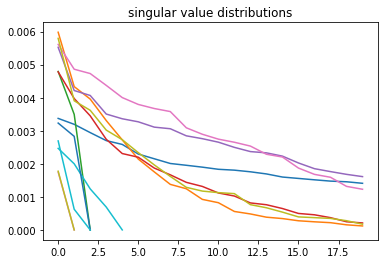

In [36]:
'''plot some points in cluster'''
def plot_pts_in_cluster(bin_id):
    points, center = X[np.where(kmeans.labels_ == bin_id)], zs[bin_id]
    
#     pp = np.vstack([points, center])
    pp = points - np.mean(points, axis = 0)
    print pp.shape
    u, s, v = np.linalg.svd(pp)
    plt.plot(s)
    return v[0], s[0] / sum(s) if sum(s) > 0 else 1

plt.title('singular value distributions')
largest_spread_eigen, percentages = np.zeros((k,d)), []
for i in range(k):
    v, per = plot_pts_in_cluster(i)
    largest_spread_eigen[i] = v
    percentages.append(per)


(array([  4.,   2.,   0.,   1.,   1.,   1.,   0.,   1.,   0.,  10.]),
 array([ 0.0818408 ,  0.17365672,  0.26547264,  0.35728856,  0.44910448,
         0.5409204 ,  0.63273632,  0.72455224,  0.81636816,  0.90818408,  1.        ]),
 <a list of 10 Patch objects>)

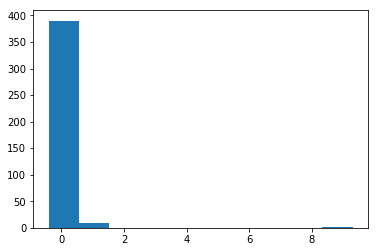

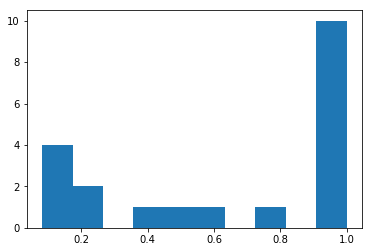

In [37]:
dists = np.dot(largest_spread_eigen.T, largest_spread_eigen)
# pretty_print(dists)
plt.hist(dists.flatten())
plt.figure()
plt.hist(percentages)

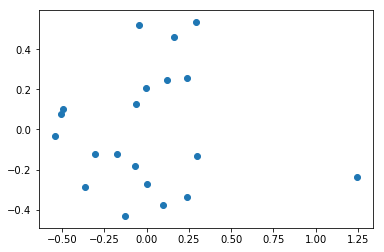

In [48]:
l2d = project_2d(largest_spread_eigen)
plt.scatter(l2d[:,0],l2d[:,1])

(array([  5.,  14.,  20.,  18.,   9.,  11.,  10.,  11.,   1.,   1.]),
 array([ 0.14127249,  0.22714524,  0.31301799,  0.39889074,  0.4847635 ,
         0.57063625,  0.656509  ,  0.74238175,  0.8282545 ,  0.91412725,  1.        ]),
 <a list of 10 Patch objects>)

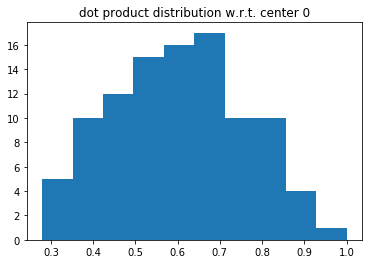

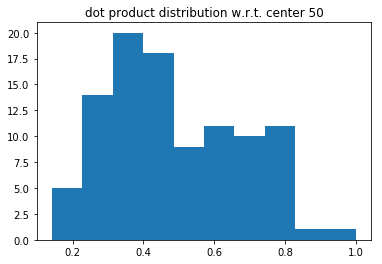

In [73]:
plt.figure()
plt.title('dot product distribution w.r.t. center 0')
plt.hist(dot_products[0])

plt.figure()
plt.title('dot product distribution w.r.t. center 50')
plt.hist(dot_products[50])

In [ ]:
'''structure within bins'''
def plot_bin(bin_id):
    points, center = X[np.where(kmeans.labels_ == bin_id)], zs[bin_id]
    print(points.shape, center.shape)

    dot_products = [np.dot(points[i], center) for i in range(points.shape[0])]
    plt.figure()
    plt.title('Bin {}: {} dot products with center'.format(bin_id, points.shape[0]))
    plt.hist(dot_products)
    
plot_bin(0)
plot_bin(10)

(17, 2) (2,)


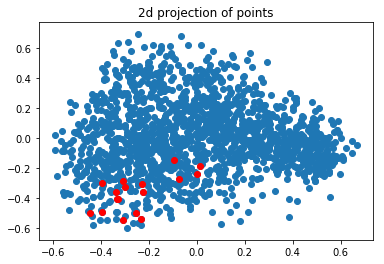

In [75]:
'''Plot the clusters'''
x2d = project_2d(X)
plt.figure()
plt.title('2d projection of points')
plt.scatter(x2d[:,0], x2d[:,1])

bin_id = 50
points = x2d[np.where(kmeans.labels_ == bin_id)]
center = np.mean(points, axis=0)
print points.shape, center.shape
plt.scatter(points[:,0], points[:,1], color='r')

## ARCHIVE

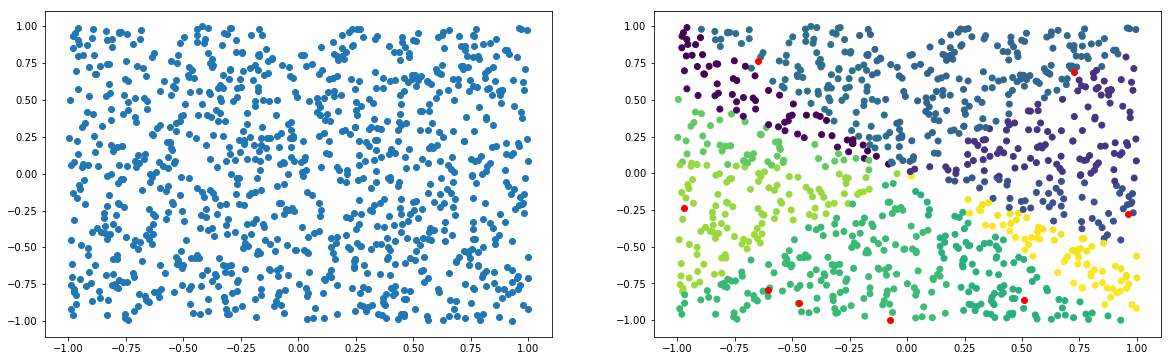

In [3]:
def main(shape):
    X = sample_uniform(-1, 1, shape)
#     X = sample_unit_ball(shape)
    hashed, zs = bin_hash(X)
    
#     Xz_2d = project_2d(np.vstack([X,zs]))
    Xz_2d = np.vstack([X,zs])
    plt.figure(figsize=(20,6))
    plt.subplot(121)
    X_2d = Xz_2d[:shape[0],:]
    plt.scatter(X_2d[:,0], X_2d[:,1])
    z_2d = Xz_2d[shape[0]:,:]
    if __DEBUG__:
        print "Hashed to {} bins".format(len(np.unique(hashed)))
        print np.unique(hashed)
    
    plt.subplot(122)
    plt.scatter(X_2d[:,0], X_2d[:,1], c=hashed)
    plt.scatter(z_2d[:,0],z_2d[:,1], c='red')
    
main((1000,2))

(121, 20)


(array([  7.,   1.,   9.,  17.,  25.,  24.,  19.,  16.,   2.,   1.]),
 array([ 0.92622917,  0.99389479,  1.06156041,  1.12922604,  1.19689166,
         1.26455728,  1.33222291,  1.39988853,  1.46755415,  1.53521978,
         1.6028854 ]),
 <a list of 10 Patch objects>)

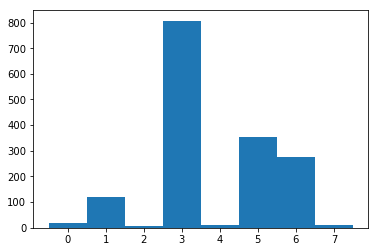

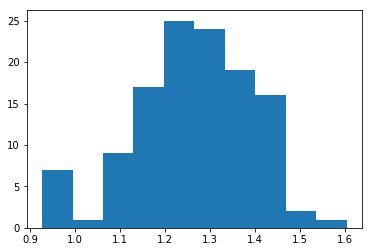

In [92]:
'''see how nearest_bin behave'''
# X = Xs[...,-1]
k = 8
bins, binvals, zs, bin_dists = nearest_bin(X,k = k)
# pretty_print(bin_dists)

# show bins histogram
plt.hist(bins, bins=np.array(range(k+1))-0.5)

# select out bin 1 and see the dot product histogram
X1 = X[np.where(bins==1)]
print X1.shape
bin1 = binvals[np.where(bins==1)]
bin1 = np.arccos(bin1)
# print bin1
plt.figure()
plt.hist(bin1)

In [18]:
def find_negative_dot_product_hash(X, k = 1, zs =None, labels = None, bound = 1):
    start_time = time.time()
    
    h, _ = X.shape
    _, centers = in_class_variance(X, labels, k)
    bins, in_cluster_angles = {}, {}  #cid -> vectors, cid -> angle between x_i and center_i
    max_angles = np.zeros(k)
    for i in range(k):
        idx = np.where(labels==i)
        a = X[idx]
        bins[i] = a, idx[0]
        in_cluster_angles[i] = np.arccos(np.dot(a, centers[i][:, np.newaxis]) - EPSILON)
        max_angles[i] = np.max(in_cluster_angles[i])
        
    center_angles = np.arccos(np.dot(centers, centers.T) - EPSILON)
    ret = np.zeros((h,h))
    N, skipped = 0, 0
    pi_over_2 = np.pi/2
    for i in range(k):
        for j in range(k):
            if i == j or center_angles[i,j] + max_angles[i] + max_angles[j] < pi_over_2 + bound/ 2: 
                skipped += 1
                continue
            angles1, angles2, center_angle = in_cluster_angles[i], in_cluster_angles[j], center_angles[i,j]
            xx1, idx1 = bins[i]
            xx2, idx2 = bins[j]
            for m in range(len(idx1)):
                for n in range(len(idx2)):
                    if center_angle + angles1[m] + angles2[n] < pi_over_2 + bound :
                        continue
                    else:
                        dot_p = np.dot(xx1[m], xx2[n])
                        N += 1
                        if dot_p < 0:
                            ret[idx1[m], idx2[n]] = dot_p
    
    end_time = time.time()
    print("Compute {} dot products in {} seconds. {}".format(N,end_time-start_time, skipped * 1. / k/ k))
    return ret

k=20
s1 = time.time()
kmeans = KMeans(n_clusters=k).fit(X)
_, zs= in_class_variance(X, kmeans.labels_, k)
hash_result, debug_info = find_negative_dot_product_hash(X, zs=zs, k = k)
s2 = time.time()
print("[k={}] Accuracy {:.2f}%. Total time: {} secs".format(k,100 * neg_accuracy(hash_result, bf_result), s2-s1))

/Users/zhuyifan/anaconda/lib/python2.7/site-packages/numpy/core/fromnumeric.py:2909: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/zhuyifan/anaconda/lib/python2.7/site-packages/numpy/core/_methods.py:73: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
/Users/zhuyifan/anaconda/lib/python2.7/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


ValueError: zero-size array to reduction operation maximum which has no identity